In [66]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly
from fbprophet import Prophet 
from sodapy import Socrata
from fbprophet.diagnostics import cross_validation 
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics

This Jupyter Notebook accompanies a blog post about using Facebook Prophet time series forecasting tool. Feel free to check it out here! https://medium.com/@wvsharber/exploratory-time-series-analysis-and-prediction-with-facebooks-prophet-6a28015d551e?sk=17ec5787eeb05e4950622af5662cb945

## Load data from Seattle Crimes Website

In [26]:
#Download some data from the Seattle crime database using the Socrata API
#Set client
client = Socrata("data.seattle.gov", None)

#Simple for-loop to gather a few years of data from the API, which limits you to 1000 results per call without an 
#API token, and store results in a pandas DataFrame
results_df = pd.DataFrame()
for x in range(0, 5000, 1000):
    results = client.get("4fs7-3vj5", offset = x, where = "((occ_datetime > '2015-01-01T00:00:00.000') AND (occ_datetime < '2019-10-01T00:00:00.000')) AND ((crime_description = 'LIQUOR LAW VIOLATION') OR (crime_description = 'DUI-LIQUOR'))")
    results_df = pd.concat([results_df, pd.DataFrame.from_records(results)], axis = 0, ignore_index = True)

#Count number of crimes per day and reset column headers to names specific for Prophet
counts_df = pd.DataFrame(results_df.groupby('occ_datetime').size().reset_index(name='counts'))
counts_df = counts_df.rename(columns = {'occ_datetime': 'ds', 'counts': 'y'})

## Use Prophet to model daily alcohol-related crimes

Prophet uses the same style API as scikit-learn: instantiate the class object, fit the model, then predict!

In [71]:
#Instantiate the Prophet class
p = Prophet()

#Fit the model 
p.fit(counts_df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecast into the future!

In [72]:
#Make a DataFrame with dates in the future using the helper function
future = p.make_future_dataframe(periods=365)

#Predict into the future (this step takes a little while)
forecast = p.predict(future)

In [59]:
#Check out a couple metrics of the predictions
forecast['yhat'].describe()

count    1803.000000
mean        3.016818
std         0.944940
min         0.621862
25%         2.247774
50%         2.806051
75%         3.850827
max         7.915260
Name: yhat, dtype: float64

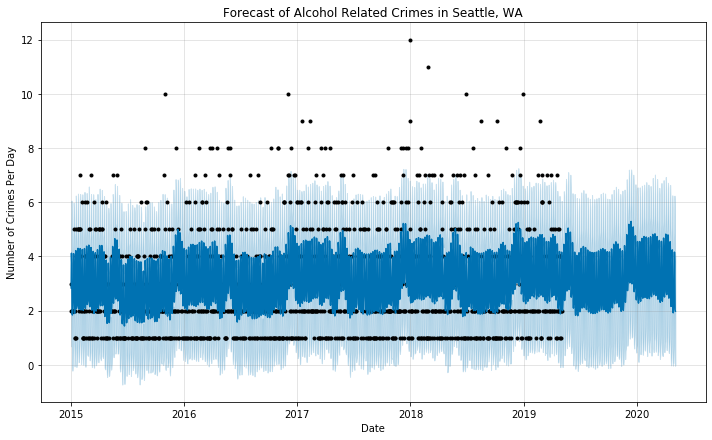

In [76]:
#Plot the data and predictions with their confidence intervals
fig1 = p.plot(forecast, xlabel = 'Date', ylabel = "Number of Crimes Per Day")
plt.title("Forecast of Alcohol Related Crimes in Seattle, WA")
plt.savefig('fig1.png', dpi=300, bbox_inches='tight');


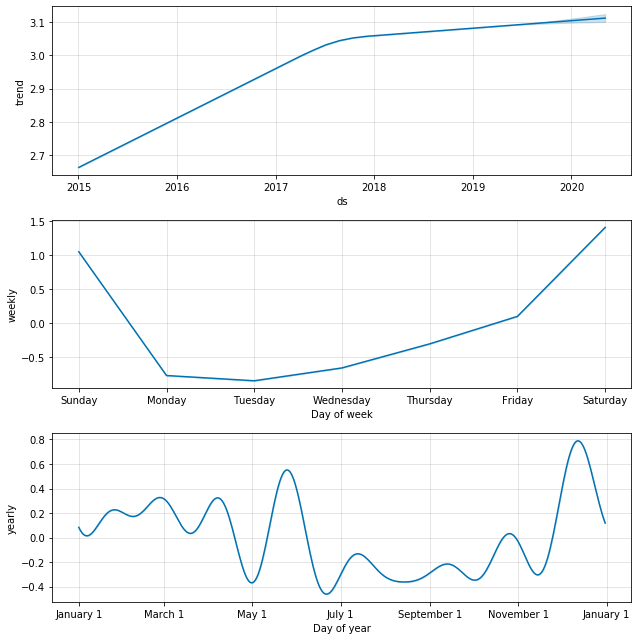

In [104]:
#Examine the components of the forecast with built-in components plot
fig2 = p.plot_components(forecast)
plt.savefig('fig2.png', dpi=300, bbox_inches='tight');

## Evaluate the model with cross validation

In [81]:
#Prophet has a built-in function for cross-validation, which isn't exactly like traditional cross-validation in a 
#machine learning setting. Here the model predicts across a test period known as the horizon, which is then compared
#to the actual data from that same period.

df_cv = cross_validation(p, horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-05-06 00:00:00 and 2018-05-06 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-05-07,2.050760,0.046282,4.140959,2,2018-05-06
1,2018-05-08,2.133947,-0.073042,4.157212,2,2018-05-06
2,2018-05-09,2.283698,0.220812,4.093878,1,2018-05-06
3,2018-05-10,2.673065,0.723434,4.659863,6,2018-05-06
4,2018-05-11,3.190052,1.225287,5.259828,4,2018-05-06


In [112]:
#We can then calculate metrics such as MAE, MSE, or RMSE with another built-in function.

df_p = performance_metrics(df_cv)
df_p['rmse'].mean()

1.6283402549277546

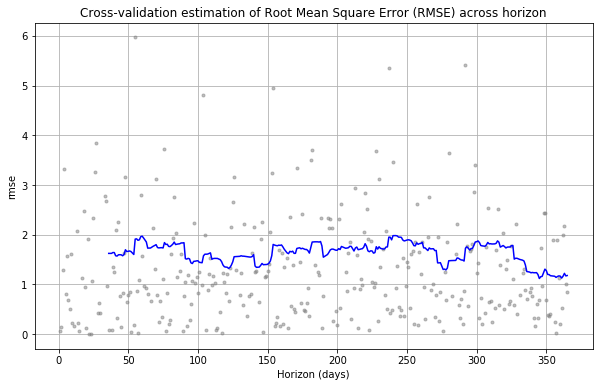

In [88]:
#Finally, we can plot the estimated errors across the horizon. This method includes a rolling calculation across
#10% of the data, represented by the blue line.

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')
plt.title("Cross-validation estimation of Root Mean Square Error (RMSE) across horizon")
plt.savefig("fig3.png", dpi=300, bbox_inches='tight')


## Repeat the process including Holiday Effects

In [100]:
#Add US holidays, since alcohol crimes spike near holidays (especially New Year!)
p2 = Prophet()
p2.add_country_holidays('US') #automatically adds holidays to the model
p2.fit(counts_df)
future2 = p2.make_future_dataframe(periods=365)
forecast2 = p2.predict(future2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


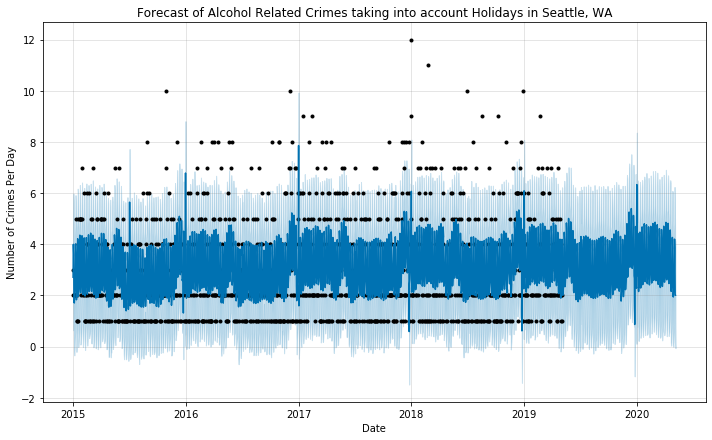

In [107]:
fig4 = p2.plot(forecast2, xlabel = 'Date', ylabel = "Number of Crimes Per Day")
plt.title("Forecast of Alcohol Related Crimes taking into account Holidays in Seattle, WA")
plt.savefig('fig4.png', dpi=300, bbox_inches='tight');


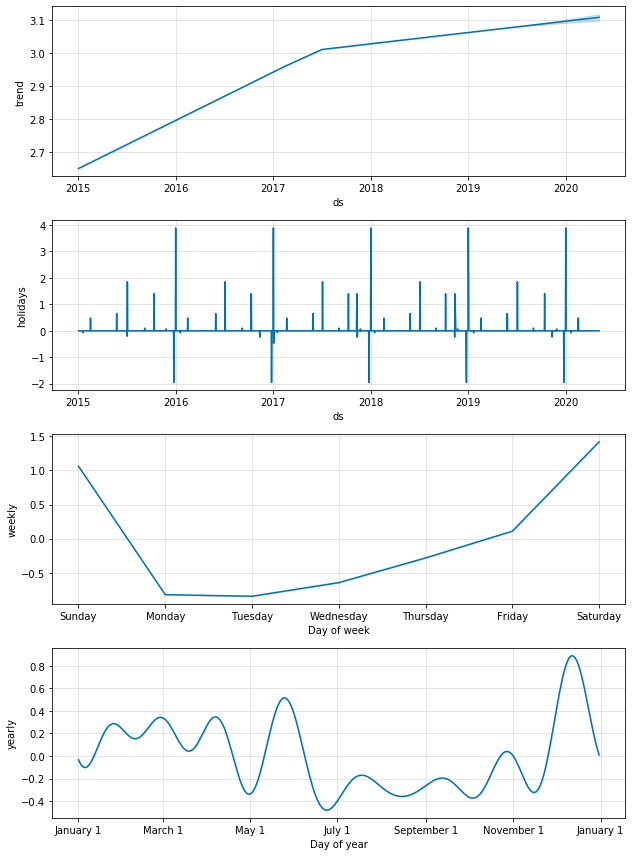

In [110]:
fig5 = p2.plot_components(forecast2)
plt.savefig('fig5.png', dpi=300, bbox_inches='tight');

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-05-06 00:00:00 and 2018-05-06 00:00:00


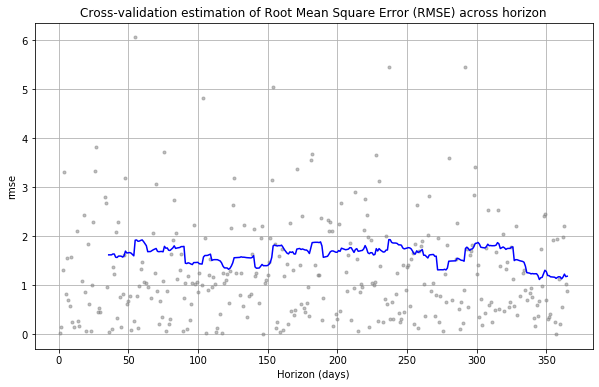

In [111]:
df_cv2 = cross_validation(p2, horizon = '365 days')
df_p2 = performance_metrics(df_cv2)
fig6 = plot_cross_validation_metric(df_cv2, metric='rmse')
plt.title("Cross-validation estimation of Root Mean Square Error (RMSE) across horizon")
plt.savefig("fig6.png", dpi=300, bbox_inches='tight')